# Attributions for off-the-shelf Siamese Encoders - Demo

In [13]:
import torch
from sentence_transformers.models import Pooling
from xsbert import models, utils
import pandas as pd
from collections import defaultdict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### loading off-the-shelf model

You can load off-the-shelf models from huggingface, initialize them as sentence transformers and wrap them with our explainer models to compute attributions for them. We currently support MP-Net (`models.XSMPNet`) and RoBERTa (`models.XSRoberta`) architectures.

In [3]:
# transformer = models.ReferenceTransformer('tceron/sentence-transformers-party-similarity-by-domain')
transformer = models.ReferenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
pooling = Pooling(transformer.get_word_embedding_dimension())
model = models.XSRoberta(modules=[transformer, pooling]) 
model.to(torch.device('cuda:1'))

XSRoberta(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### initializing attributions

The `init_attribution_to_layer()` method of the `models.XSTransformer` class initializes attributions to the layer with index `idx`. `N_steps` is the number of approximation steps to calculate the *integrated Jacobians* ($N$ in the paper).

`reset_attribution()` removes all hooks that are registered on the model for calculating attributions. After calling it, you can initialize attributions to a different layer.

In [4]:
model.reset_attribution()
model.init_attribution_to_layer(idx=10, N_steps=100)

No hook has been registered.


### computing attributions

In this demo we compute the attribution matrix for a single pair of texts that you can define here:

In [28]:
df = pd.read_csv('../capture_similarity_between_political_parties/data/sentence_pairs.csv', index_col=0)

After initializing attributions (above), we use the method `attribute_prediction` in the `models.XSTransformer` class to compute the attribution matrix $A$.

In [6]:
k = 2
texta = df.sentence1.tolist()[k]
textb = df.sentence2.tolist()[k]   
print(texta)
print(textb) 

Mit ihr endet eine Ära und eine neue kann beginnen.
Wir sehen aber auch Entwicklungen, die geändert oder gestoppt werden müssen, um eine gute Zukunft möglich zu machen.


In [16]:
def generate_explanation(texta, textb):
    A, tokens_a, tokens_b = model.explain_similarity(
        texta, 
        textb, 
        move_to_cpu=True,
        sim_measure='cos',
    )
    return A, tokens_a, tokens_b

### plotting attributions

Finally, we can plot the token-token attribution matrix.

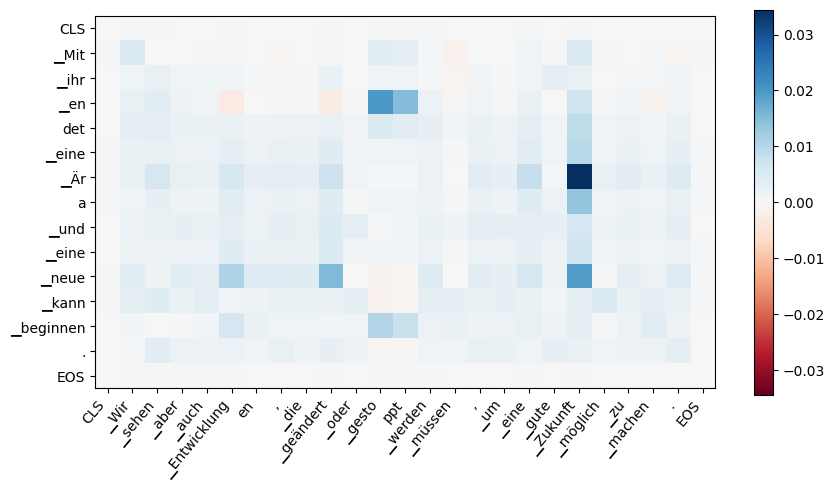

In [8]:
f = utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    size=(10, 10),
    # range=.3,
    show_colorbar=True, 
    shrink_colorbar=.5
)
f.show()

In [ ]:
def retrieve_tokens_high_similarity(A, tokens_a, tokens_b, k):
    """ Retrieve indexes from texta and textb with similarity higher than k according to the attributions in matrix A """
    list_tokens = []
    for i, token_a in enumerate(tokens_a):
        for j, token_b in enumerate(tokens_b):
            sim = A[i, j]
            if sim > k:
                max_sim_idx = (i, j)
                list_tokens.append((token_a, token_b))

    return list_tokens

In [29]:
print(df)
df = df[(df["party1"]=="gruene")&(df["party2"]=="fdp")]
party_tokens = defaultdict(list)
for row in df.iterrows():
    texta = row[1].sentence1
    textb = row[1].sentence2
    print(texta)
    A, tokens_a, tokens_b = generate_explanation(texta, textb)
    similar_tokens = retrieve_tokens_high_similarity(A, tokens_a, tokens_b, k=0.01)
    print(similar_tokens)
    party_tokens[(row[1].party1, row[1].party2)].extend(similar_tokens)
    print(row[1].party1)

    

                                                   model  party1  party2  \
0       sentence-transformers-party-similarity-by-domain  gruene     spd   
1       sentence-transformers-party-similarity-by-domain  gruene     spd   
2       sentence-transformers-party-similarity-by-domain  gruene     spd   
3       sentence-transformers-party-similarity-by-domain  gruene     spd   
4       sentence-transformers-party-similarity-by-domain  gruene     spd   
...                                                  ...     ...     ...   
187654   sentence-transformers-party-similarity-by-party   linke  gruene   
187655   sentence-transformers-party-similarity-by-party   linke  gruene   
187656   sentence-transformers-party-similarity-by-party   linke  gruene   
187657   sentence-transformers-party-similarity-by-party   linke  gruene   
187658   sentence-transformers-party-similarity-by-party   linke  gruene   

                                                sentence1  \
0       Liebe Wähler*innen

100%|██████████| 384/384 [00:01<00:00, 293.62it/s]


[('▁Wähle', '▁Das'), ('▁Wähle', '▁Wahl'), ('▁Wähle', '▁politischen'), ('r', '▁Wahl'), ('r', '▁politischen'), ('▁durch', '▁Wahl'), ('▁Wahl', '▁Das'), ('▁Wahl', '▁Wahl'), ('▁Wahl', '▁politischen'), ('en', '▁Wahl'), ('en', '▁politischen'), ('▁entscheidet', '▁Wahl')]
gruene
Das gilt erst recht für diese Bundestagswahl am 26. September.


100%|██████████| 384/384 [00:02<00:00, 165.62it/s]


[('▁für', 'wahl'), ('▁diese', 'wahl'), ('▁Bundestag', '▁Bundestag'), ('▁Bundestag', '▁Bundes'), ('▁Bundestag', '598'), ('s', 'wahl'), ('wahl', 'wahl'), ('▁September', '598')]
gruene
Mit ihr endet eine Ära und eine neue kann beginnen.


100%|██████████| 384/384 [00:01<00:00, 218.25it/s]


[('▁Är', '▁Sozial'), ('▁Är', '▁Zukunft'), ('▁Är', '▁Wandel'), ('▁neue', '▁Zukunft'), ('▁neue', '▁Wandel')]
gruene
Sie, liebe Wähler*innen, können mit Ihrer Stimme selbst entscheiden, welche Richtung sie nimmt.


100%|██████████| 384/384 [00:01<00:00, 289.54it/s]


[('▁Wähle', '▁demokrati'), ('▁Wähle', 'scher'), ('r', '▁demokrati'), ('r', 'scher'), ('▁Stimme', '▁demokrati'), ('▁sie', '▁demokrati')]
gruene
Wir, BÜNDNIS 90/DIE GRÜNEN, legen mit diesem Programm unser inhaltliches Angebot an Sie vor.


100%|██████████| 384/384 [00:01<00:00, 217.12it/s]


[('▁Wir', '▁unserer'), ('▁90', 'wässer')]
gruene
Wir tun dies in einer Zeit des globalen Ausnahmezustands.


100%|██████████| 384/384 [00:01<00:00, 264.86it/s]


KeyboardInterrupt: 